In [1]:
import numpy as np
import matplotlib as plt
from PIL import Image
import os
import glob
import scipy.io
import time
import yaml
from utils import *
from scipy.ndimage import gaussian_filter
from skimage.restoration import unwrap_phase

config_name = 'BPRA_ana'
config_path = f'./configs/recon/{config_name}.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Unpack configuration settings
folder = config["folder"]
phase_object = config["phase_object"]
elliptical_pupil = config["elliptical_pupil"]
pupil_edge_soften = config["pupil_edge_soften"]
pre_process = config["pre_process"]
equalization = config["equalization"]
wfe_correction = config["wfe_correction"]
wfe_alpha = config["wfe_alpha"]
data_format = config["data_format"]
keyword = config["keyword"]
index_to_exclude = config["index_to_exclude"]
roi_size_px = config["roi_size_px"]
use_ROI = config["use_ROI"]
ROI_length = config["ROI_length"]
ROI_center = config["ROI_center"]
init_option = config["init_option"]
file_name = config["file_name"]
recon_alg = config["recon_alg"]
abe_correction = config["abe_correction"]
swap_dim = config["swap_dim"]

iters = 1000
recon_init = True

#%% Set up parameters
# wavelength of acquisition
lambda_m = 13.5e-9

if elliptical_pupil:
    dx_m = 10.8e-9
else:
    dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)

if elliptical_pupil:
    fc_lens = (np.arcsin(.55/4)/lambda_m)
    a = fc_lens  # semi-major axis
    b = fc_lens / 2  # semi-minor axis
    FILTER = ((Fx/a)**2 + (Fy/b)**2) <= 1

    # # Take 20% obscuration into account
    a_ob = a*0.2
    b_ob = b*0.2
    FILTER[(Fx/a_ob)**2 + (Fy/b_ob)**2 <= 1] = 0
else:
    fc_lens = (np.arcsin(.33/4)/lambda_m)
    FILTER = (Fx**2 + Fy**2) <= fc_lens**2


#%% Load data
if data_format == 'img':
    # Find all .png files in the folder
    files = glob.glob(os.path.join(folder, f"{keyword}_sx*.png"))
    img = []
    sx = []
    sy = []

    for filename in files:
        img_0 = np.array(Image.open(filename)).astype(float)
        img.append(img_0)
        filename = os.path.basename(filename)
        sx_0 = float(filename[-17:-12])
        # sx_0 = float(filename[-20:-15])
        sy_0 = float(filename[-9:-4])
        sx.append(sx_0)
        sy.append(sy_0)

elif data_format == 'mat':
    path = folder + keyword + '.mat'
    data = scipy.io.loadmat(path)
    img = data['I_low']
    img = [img[:,:,i] for i in range(img.shape[2])]
    na_calib = data['na_calib']
    na_calib = na_calib/(fc_lens*lambda_m)
    sx = [na_calib[i, 0] for i in range(na_calib.shape[0])]
    sy = [na_calib[i, 1] for i in range(na_calib.shape[0])]
    
elif data_format == 'npz':
    path = folder + keyword + '.npz'
    data = np.load(path)
    img = data['imgs']
    img = [img[i,:,:] for i in range(img.shape[0])]
    sx = data['sx']
    sy = data['sy']
    
if index_to_exclude is not None:
    img = [img[i] for i in range(len(img)) if i+1 not in index_to_exclude]
    sx = [sx[i] for i in range(len(sx)) if i+1 not in index_to_exclude]
    sy = [sy[i] for i in range(len(sy)) if i+1 not in index_to_exclude]

print(f"Reconstructing with {len(img)} images")
    
if pre_process:
    binaryMask = (Fx**2 + Fy**2) <= (2*fc_lens)**2
    
    # Taper the edge to avoid ringing effect
    from scipy.ndimage import gaussian_filter
    xsize, ysize = img[0].shape[:2]
    edgeMask = np.zeros((xsize, ysize))
    pixelEdge = 3
    edgeMask[0:pixelEdge, :] = 1
    edgeMask[-pixelEdge:, :] = 1
    edgeMask[:, 0:pixelEdge] = 1
    edgeMask[:, -pixelEdge:] = 1
    edgeMask = gaussian_filter(edgeMask, sigma=5)
    maxEdge = np.max(edgeMask)
    edgeMask = (maxEdge - edgeMask) / maxEdge


    for i in range(len(img)):
        ftTemp = ft(img[i])
        noiseLevel = max(np.finfo(float).eps, np.mean(np.abs(ftTemp[~binaryMask])))
        ftTemp = ftTemp * np.abs(ftTemp) / (np.abs(ftTemp) + noiseLevel)
        img[i] = ift(ftTemp * binaryMask) * edgeMask

    
if equalization:
    # Equalize each patch
    patch_size = 332
    for im in img:
        # calculate the energy of central patch
        cen_energy = np.sum(img[0][patch_size: 2*patch_size, patch_size: 2*patch_size])
        # equalize the energy of all patches
        for i in range(3):
            for j in range(3):
                im[i*patch_size: (i+1)*patch_size, j*patch_size: (j+1)*patch_size] *= cen_energy / np.sum(
                    im[i*patch_size: (i+1)*patch_size, j*patch_size: (j+1)*patch_size])
    # Equalize the energy of all images
    energy = np.sum(img[0])
    for im in img:
        im *= energy / np.sum(im)

if wfe_correction:
    sx = np.array(sx)
    sy = np.array(sy)
    kx = sx * fc_lens
    ky = sy * fc_lens
    k = 1 / lambda_m
    kz = np.sqrt(k**2 - kx**2 - ky**2)
    phi = np.arccos(kz / k)

    xc_m = (ROI_center[0]-int(roi_size_px/2))*dx_m
    yc_m = (ROI_center[1]-int(roi_size_px/2))*dx_m
    r_m = np.sqrt(xc_m**2 + yc_m**2)
    delta_phi = 2*8*lambda_m/((10*1e-6)**2)*r_m
            
    delta_sx = delta_phi/(fc_lens*lambda_m)*yc_m/r_m
    delta_sy = delta_phi/(fc_lens*lambda_m)*xc_m/r_m
    sx_corrected = sx + wfe_alpha * delta_sx
    sy_corrected = sy + wfe_alpha * delta_sy

    sx, sy = sx_corrected, sy_corrected


#%% Crop ROI
if use_ROI:
    print(f'Using ROI of size {ROI_length}')
    x_m = x_m[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2)]
    y_m = y_m[ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)]
    img = [i[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2), 
             ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)] for i in img]
    if elliptical_pupil:
        a = fc_lens  # semi-major axis
        b = fc_lens / 2  # semi-minor axis
        X_full = [sx*a*Dx_m for sx in sx]
        Y_full = [sy*b*Dx_m for sy in sy]
    else:
        X_full = [sx*fc_lens*Dx_m for sx in sx]
        Y_full = [sy*fc_lens*Dx_m for sy in sy]
    X = [int(x/roi_size_px*ROI_length) for x in X_full]
    Y = [int(y/roi_size_px*ROI_length) for y in Y_full]
     
    roi_size_px = min(ROI_length, roi_size_px)
    Dx_m = ROI_length * dx_m
    Nfft = len(x_m)
    df = fs / Nfft
    freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2
    Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
    if elliptical_pupil:
        fc_lens = (np.arcsin(.55/4)/lambda_m)
        a = fc_lens
        b = fc_lens / 2
        FILTER = ((Fx/a)**2 + (Fy/b)**2) <= 1
        a_ob = a*0.2
        b_ob = b*0.2
        FILTER[(Fx/a_ob)**2 + (Fy/b_ob)**2 <= 1] = 0
    else:
        fc_lens = (np.arcsin(.33/4)/lambda_m)
        FILTER = (Fx**2 + Fy**2) <= fc_lens**2
else:
    if elliptical_pupil:
        a = fc_lens
        b = fc_lens / 2
        X = [int(x*a*Dx_m) for x in sx]
        Y = [int(y*b*Dx_m) for y in sy]
    else:
        X = [int(x*fc_lens*Dx_m) for x in sx]
        Y = [int(y*fc_lens*Dx_m) for y in sy]


if swap_dim:
    X, Y = Y, X

lens_init = get_lens_init(FILTER, init_option, file_name)
spectrum_guess = ft(np.sqrt(img[0]))
object_guess = ift(spectrum_guess)
lens_guess = np.complex128(lens_init)

meas = np.array(img)
print(meas.shape)
print(meas.min(), meas.max())

Reconstructing with 40 images
Using ROI of size 332
(40, 332, 332)
579.0 10354.0


In [2]:
if recon_init:
    def load_recon(folder, recon_alg, downsample=False):
        if recon_alg == 'APIC':
            filename = f'{folder}result/{keyword}_APIC_{str(ROI_length)}.mat'
            recon = scipy.io.loadmat(filename)
            object_guess = recon['himMatching']
            pupil_recon = recon['CTF_abe']
            pupil_recon = np.fliplr(pupil_recon)
            pupil_recon = np.flipud(pupil_recon)
        else:
            recon = scipy.io.loadmat(f'{folder}/result/{config_name}_{recon_alg}_recon.mat')
            object_guess = recon['obj']
            if 'pupil' in recon:
                pupil_recon = recon['pupil']
                full_recon_flag = False
            else:
                pupil_recon = recon['pupil_array']
                full_recon_flag = True
            ideal_FILTER = recon['ideal_FILTER']

        if downsample:        
            if recon_alg == 'GN' or recon_alg == 'APIC':
                downsampled_size = ROI_length
                size_px = object_guess.shape[0]
                object_guess = ft(object_guess)
                object_guess = object_guess[size_px//2-downsampled_size//2:size_px//2+downsampled_size//2, size_px//2-downsampled_size//2:size_px//2+downsampled_size//2]
                object_guess = ift(object_guess)
        
        return object_guess, pupil_recon, ideal_FILTER, full_recon_flag
    
    object_guess, pupil_recon, _, _ = load_recon(folder, recon_alg, downsample=True)
    spectrum_guess = ft(object_guess)
    lens_guess = pupil_recon
    
    

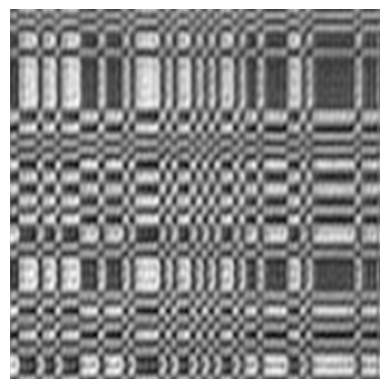

<Figure size 640x480 with 0 Axes>

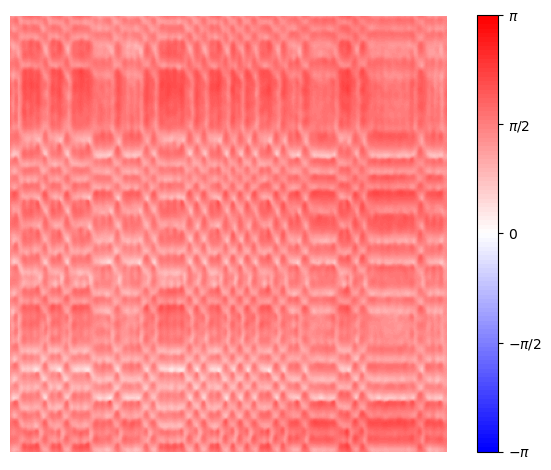

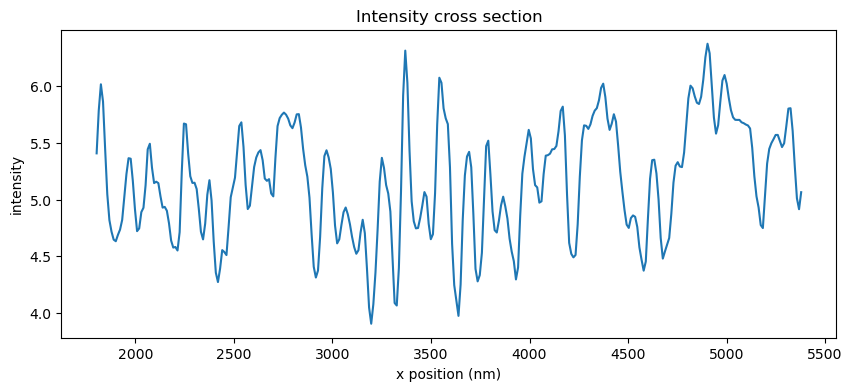

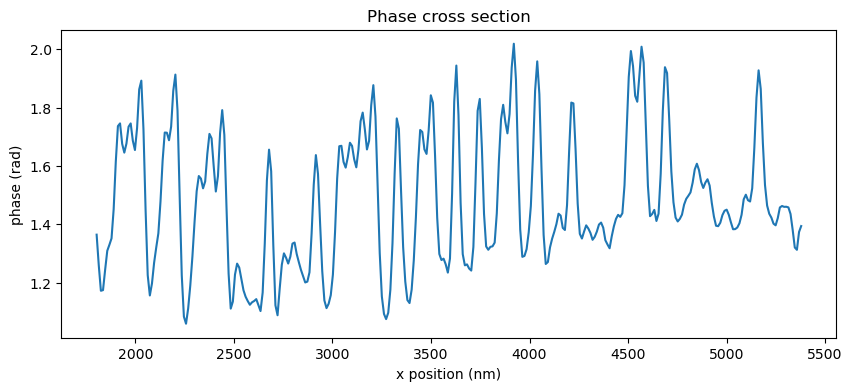

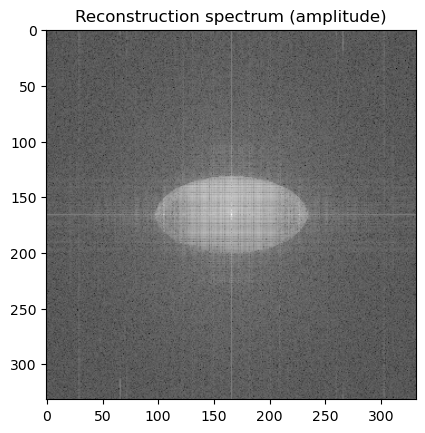

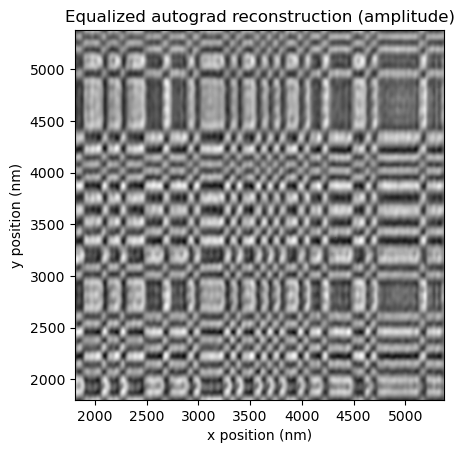

Amplitude loss: 25.43644142150879
Feature loss: 2.2297556400299072


In [3]:
import torch
from tqdm.notebook import tqdm

# use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# normalization
# meas = np.float32(meas)
# meas = meas / np.max(meas)
# spectrum_guess = ft(np.sqrt(meas[0]))

# centered 2D Fourier Transform
ft_torch = lambda s: torch.fft.fftshift(
    torch.fft.fft2(
        torch.fft.ifftshift(s, dim=(-2, -1)),
        dim=(-2, -1)
    ), dim=(-2, -1)
)

# centered 2D Inverse Fourier Transform
ift_torch = lambda s: torch.fft.fftshift(
    torch.fft.ifft2(
        torch.fft.ifftshift(s, dim=(-2, -1)),
        dim=(-2, -1)
    ), dim=(-2, -1)
)

# circular shift (2D)
circshift2_torch = lambda x, sx, sy: torch.roll(
    torch.roll(x, int(round(sx)), dims=1),
    int(round(sy)), dims=0
)

def subpixel_circshift2_torch(F, shift_x, shift_y):
    """
    Shift the 2D frequency-domain array F by (shift_x, shift_y)
    using the real-domain multiplication trick.
    
    F: shape (H, W) with complex dtype, representing F(u,v).
    shift_x, shift_y: sub-pixel shifts in frequency space (in array indices).
    """
    # 1) Inverse FFT to real domain
    f = ift_torch(F)  # shape (H, W), complex

    # 2) Build phase ramp in real space
    H, W = f.shape
    xx = torch.arange(W, device=f.device).reshape(1, -1).float()
    yy = torch.arange(H, device=f.device).reshape(-1, 1).float()

    # Convert pixel shift in freq domain -> phase ramp in real domain
    phase_ramp = 2.0 * np.pi * (
        (shift_x * xx / W) + (shift_y * yy / H)
    )  # shape (H, W)
    ramp = torch.exp(1j * phase_ramp)
    f_shifted = f * ramp
    F_shifted = ft_torch(f_shifted)
    return F_shifted


def FP_forward(spectrum_guess, lens_guess, X, Y):
    E_pred_list = []
    for idx in range(len(X)):
        shifted_spectrum = subpixel_circshift2_torch(spectrum_guess, X[idx], Y[idx])
        E_pred = ift_torch(shifted_spectrum * lens_guess)  # Complex wave
        E_pred_list.append(E_pred)
    return torch.stack(E_pred_list)


def get_corrected_illumination(X, Y, factors):
    kx = X/Dx_m
    ky = Y/Dx_m
    
    xc_m = (ROI_center[0] - roi_size_px//2) * dx_m
    yc_m = (ROI_center[1] - roi_size_px//2) * dx_m
    r_m = np.sqrt(xc_m**2 + yc_m**2)
    
    radial_val = sum(c * (r_m ** (i + 1)) for i, c in enumerate(factors))
    delta_phi = 2.0 * 8.0 * lambda_m / ((10e-6) ** 2) * radial_val

    if r_m != 0:
        delta_kx = (delta_phi / lambda_m) * (xc_m / r_m)
        delta_ky = (delta_phi / lambda_m) * (yc_m / r_m)
    else:
        delta_kx, delta_ky = 0.0, 0.0
    
    kx_corrected = kx + delta_kx
    ky_corrected = ky + delta_ky
    
    X_corrected = kx_corrected * Dx_m
    Y_corrected = ky_corrected * Dx_m
    
    return X_corrected, Y_corrected


def plot_recon(spectrum_tensor, title_str='Autograd reconstruction'):
    spectrum_recon = spectrum_tensor.detach().cpu().numpy()
    object_recon = ift(spectrum_recon)
    plt.figure(1)
    plt.imshow(np.abs(object_recon), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
    plt.xlabel('x position (nm)')
    plt.ylabel('y position (nm)')
    # plt.title(title_str+' (amplitude)')
    plt.axis('off')
    plt.show()


    plt.figure(2)
    # Define custom colormap: Blue -> White -> Red
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_diverging', colors, N=100)
    fig, ax = plt.subplots()
    # Plot the phase of object_guess
    cax = ax.imshow(
        np.angle(object_recon),
        extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9],
        cmap=cmap, vmin=-np.pi, vmax=np.pi
    )
    ax.set_xlabel('x position (nm)')
    ax.set_ylabel('y position (nm)')
    # ax.set_title(title_str+' (phase)')
    plt.axis('off')
    cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])
    plt.tight_layout()
    plt.show()
    
    # show a cross section of the intensity and phase
    x_vals = np.linspace(x_m[0]*1e9, x_m[-1]*1e9, object_guess.shape[1])
    plt.figure(3, figsize=(10, 4))
    plt.plot(x_vals, np.abs(object_recon)[ROI_length//2, :])
    plt.xlabel('x position (nm)')
    plt.ylabel('intensity')
    plt.title('Intensity cross section')
    plt.show()

    plt.figure(4, figsize=(10, 4))
    plt.plot(x_vals, np.angle(object_recon)[ROI_length//2, :])
    plt.xlabel('x position (nm)')
    plt.ylabel('phase (rad)')
    plt.title('Phase cross section')
    plt.show()

    # show the intensity of the recon spectrum
    plt.figure(6)
    plt.imshow(np.log(np.abs(ft(object_guess)+1)), cmap='gray')
    plt.title('Reconstruction spectrum (amplitude)')
    plt.show()
    
    def remove_vignetting_with_lowpass(image, sigma=10, epsilon=1e-6):
        background = gaussian_filter(image, sigma=sigma)
        corrected = image / (background + epsilon)
        return corrected

    object_recon_equalized = remove_vignetting_with_lowpass(object_recon)

    plt.figure(7)
    plt.imshow(np.abs(object_recon_equalized), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
    plt.xlabel('x position (nm)')
    plt.ylabel('y position (nm)')
    plt.title('Equalized autograd reconstruction (amplitude)')
    plt.show()


def first_order_gradient_loss(pred_tensor, meas_tensor):
    """
    Compute MSE between the first-order (x and y) gradients of
    pred_tensor and sqrt(meas_tensor).
    """
    sqrt_meas = torch.sqrt(meas_tensor)

    # x-gradients (shift along width)
    dx_pred = pred_tensor[..., :, 1:] - pred_tensor[..., :, :-1]
    dx_meas = sqrt_meas[..., :, 1:] - sqrt_meas[..., :, :-1]

    # y-gradients (shift along height)
    dy_pred = pred_tensor[..., 1:, :] - pred_tensor[..., :-1, :]
    dy_meas = sqrt_meas[..., 1:, :] - sqrt_meas[..., :-1, :]

    loss_dx = torch.mean((dx_pred - dx_meas) ** 2)
    loss_dy = torch.mean((dy_pred - dy_meas) ** 2)

    return (loss_dx + loss_dy) * 0.5



# convert to tensor
spectrum_tensor = torch.tensor(spectrum_guess, dtype=torch.complex64, requires_grad=True, device=device)
lens_tensor = torch.tensor(lens_guess, dtype=torch.complex64, requires_grad=True, device=device)
meas_tensor = torch.tensor(meas, dtype=torch.float32, device=device)
FILTER_tensor = torch.tensor(FILTER, dtype=torch.float32, device=device)
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True, device=device)
Y_tensor = torch.tensor(Y, dtype=torch.float32, requires_grad=True, device=device)
factors = [0.0, 0.0, 0.0, 0.0, 0.0]
factors_tensor = torch.tensor(factors, dtype=torch.float32, requires_grad=True, device=device)

plot_recon(spectrum_tensor, 'Initial reconstruction')

init_pred = torch.abs(FP_forward(spectrum_tensor, lens_tensor, X, Y))

amplitude_loss = torch.mean((init_pred - torch.sqrt(meas_tensor))**2)
feature_loss = first_order_gradient_loss(init_pred, torch.sqrt(meas_tensor))
print('Amplitude loss:', amplitude_loss.item())
print('Feature loss:', feature_loss.item())


  0%|          | 0/3000 [00:00<?, ?it/s]

/tmp/ipykernel_2422889/1478959709.py:84: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(losses))


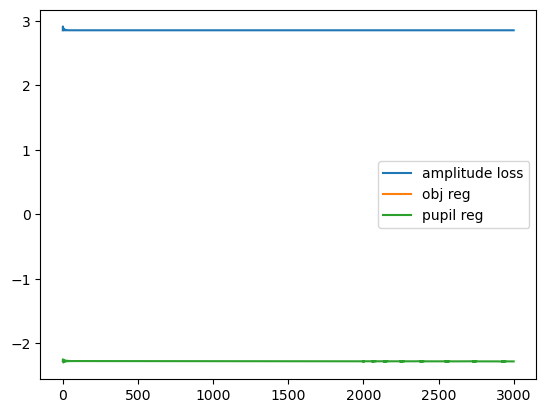

In [12]:
iters = 3000
lr_spectrum = 1e1 #1e2
lr_lens = 1e-1 #1e-1
lr_killu = 0 #1e-2
lr_factors = 1e0

regularization_dict = {'L1_obj':0, 'L2_pupil': 1e0}
# regularization_dict = {'L1_obj':1e-4, 'L2_pupil': 1e3}
loss_type = 'amplitude'       # 'feature' 'amplitude' 'intensity'
wfe_model = False
if wfe_model:
    lr_killu = 0 # the optimization of X, Y is done in the model

optimizer_spectrum = torch.optim.Adam([spectrum_tensor], lr=lr_spectrum)
optimizer_lens = torch.optim.Adam([lens_tensor], lr=lr_lens)
optimizer_killu = torch.optim.Adam([X_tensor, Y_tensor], lr=lr_killu)
optimizer_factors = torch.optim.Adam([factors_tensor], lr=lr_factors)


losses = []

# track X, Y for these three indices
tracked_indices = [0, len(X_tensor)//4, len(X_tensor)//2]
X_history = [[] for _ in range(len(tracked_indices))]
Y_history = [[] for _ in range(len(tracked_indices))]

for i in tqdm(range(iters)):
    optimizer_spectrum.zero_grad()
    optimizer_lens.zero_grad()
    optimizer_killu.zero_grad()
    optimizer_factors.zero_grad()
    
    # Forward pass
    if wfe_model:
        X_tensor_corrected, Y_tensor_corrected = get_corrected_illumination(X_tensor, Y_tensor, factors_tensor)
        E_pred = FP_forward(spectrum_tensor, lens_tensor, X_tensor_corrected, Y_tensor_corrected)
    else:
        E_pred = FP_forward(spectrum_tensor, lens_tensor, X_tensor, Y_tensor)

    # Compute the loss
    amplitude_pred = torch.abs(E_pred)
    if loss_type == 'feature':
        main_loss = first_order_gradient_loss(amplitude_pred, torch.sqrt(meas_tensor))
    elif loss_type == 'amplitude':
        main_loss = torch.mean((amplitude_pred - torch.sqrt(meas_tensor))**2)
    elif loss_type == 'intensity':
        main_loss = torch.mean((amplitude_pred**2 - meas_tensor)**2)
    else:
        raise ValueError('Invalid loss type')
    
    object_recon = ift_torch(spectrum_tensor)
    d0 = object_recon[..., 1:, :-1] - object_recon[..., :-1, :-1]
    d1 = object_recon[..., :-1, 1:] - object_recon[..., :-1, :-1]
    obj_reg = torch.mean(torch.abs(d0) + torch.abs(d1))*regularization_dict['L1_obj']
    
    d0 = lens_tensor[..., 1:, :-1] - lens_tensor[..., :-1, :-1]
    d1 = lens_tensor[..., :-1, 1:] - lens_tensor[..., :-1, :-1]
    pupil_reg = torch.mean(torch.abs(d0)**2 + torch.abs(d1)**2)*regularization_dict['L2_pupil']
    
    loss = main_loss + obj_reg + pupil_reg
    loss.backward()
    
    # Update the parameters
    optimizer_spectrum.step()
    optimizer_lens.step()
    optimizer_killu.step()
    optimizer_factors.step()
    
    with torch.no_grad():
       lens_tensor.mul_(FILTER_tensor)
    losses.append([main_loss.item(), obj_reg.item(), pupil_reg.item()])
    
    # Track the optimization progress
    with torch.no_grad():
        for i_idx, idx in enumerate(tracked_indices):
            if wfe_model:
                X_history[i_idx].append(X_tensor_corrected[idx].item())
                Y_history[i_idx].append(Y_tensor_corrected[idx].item())
            else:
                X_history[i_idx].append(X_tensor[idx].item())
                Y_history[i_idx].append(Y_tensor[idx].item())

plt.figure()    
plt.plot(np.log(losses))
plt.legend([f'{loss_type} loss', 'obj reg', 'pupil reg'])
plt.show()


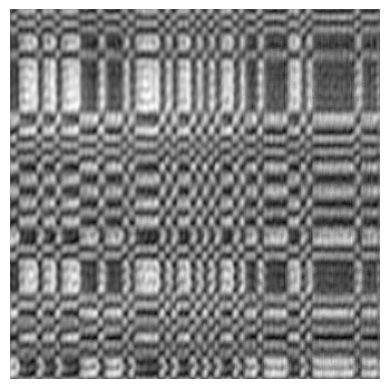

<Figure size 640x480 with 0 Axes>

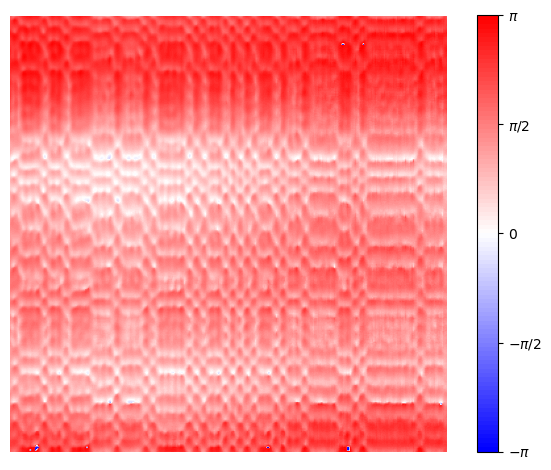

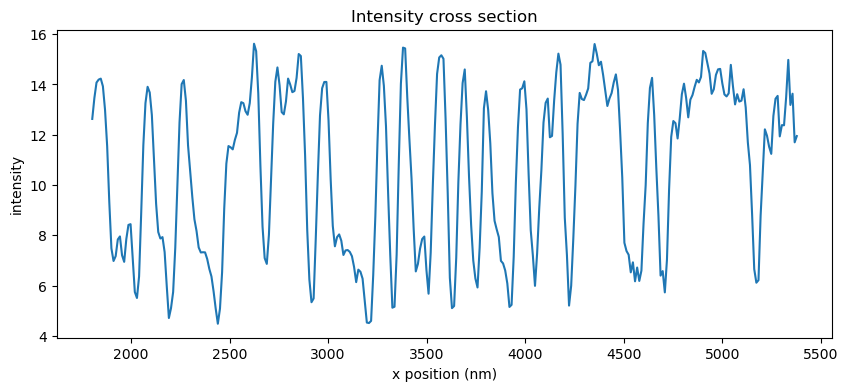

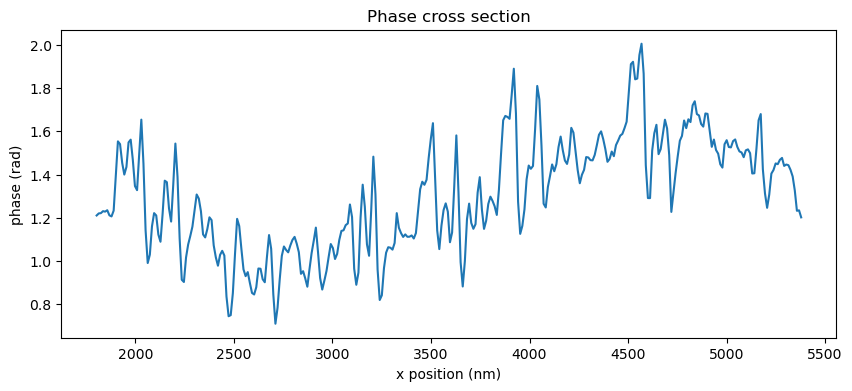

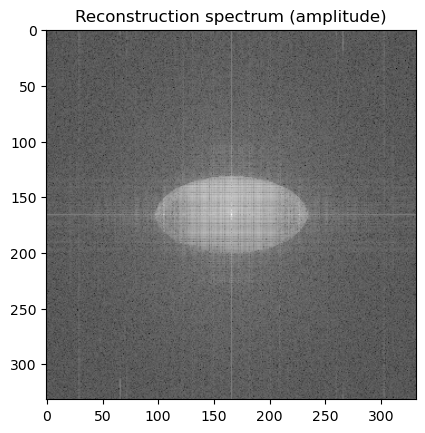

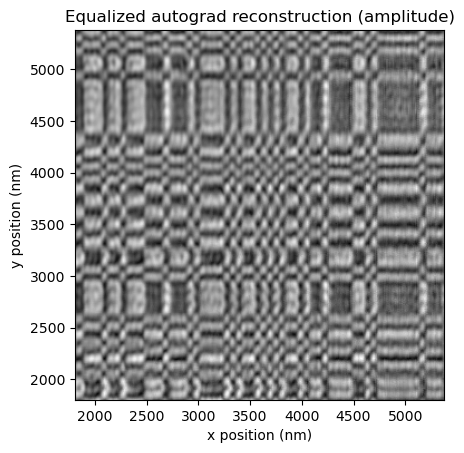

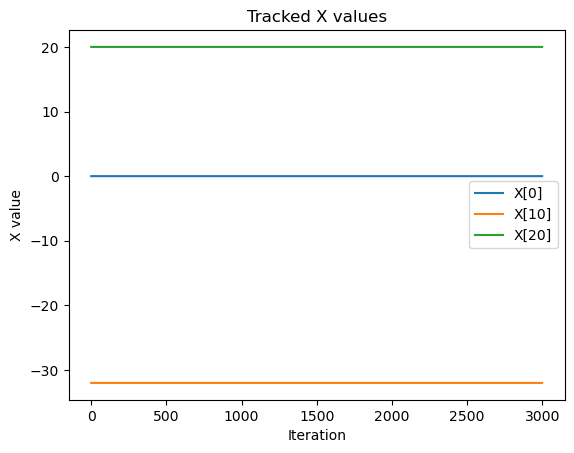

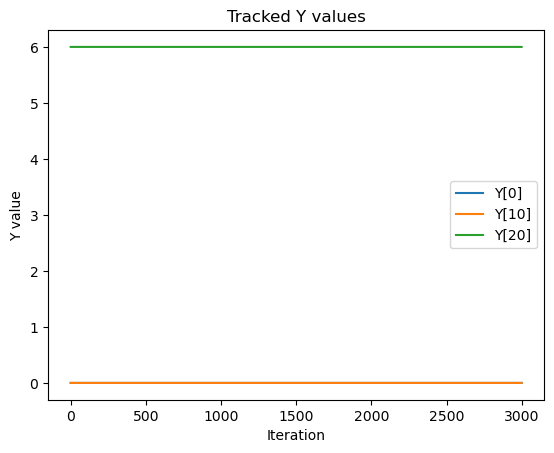

In [13]:
plot_recon(spectrum_tensor)


# Plot the tracked X values
plt.figure()
for i_idx, idx in enumerate(tracked_indices):
    plt.plot(X_history[i_idx], label=f'X[{idx}]')
plt.xlabel('Iteration')
plt.ylabel('X value')
plt.title('Tracked X values')
plt.legend()
plt.show()

# Plot the tracked Y values
plt.figure()
for i_idx, idx in enumerate(tracked_indices):
    plt.plot(Y_history[i_idx], label=f'Y[{idx}]')
plt.xlabel('Iteration')
plt.ylabel('Y value')
plt.title('Tracked Y values')
plt.legend()
plt.show()

tensor([0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)


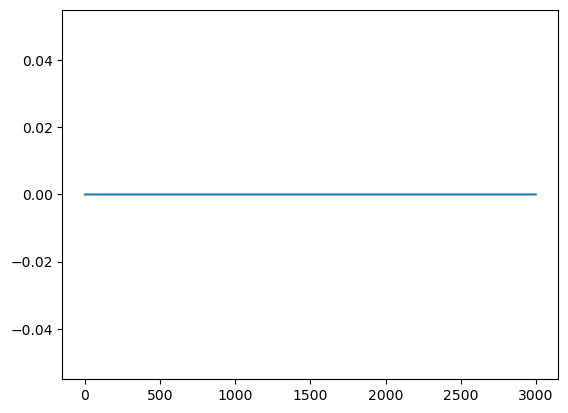

In [6]:
plt.plot(X_history[0])
print(factors_tensor)

In [7]:
print(losses[0])
print(losses[-1])

amplitude_loss = torch.mean((amplitude_pred - torch.sqrt(meas_tensor))**2)
feature_loss = first_order_gradient_loss(amplitude_pred, torch.sqrt(meas_tensor))
print('Amplitude loss:', amplitude_loss.item())
print('Feature loss:', feature_loss.item())

[25.43644142150879, 0.0, 0.3109703063964844]
[17.377540588378906, 0.0, 0.24726346135139465]
Amplitude loss: 17.377540588378906
Feature loss: 2.488656520843506


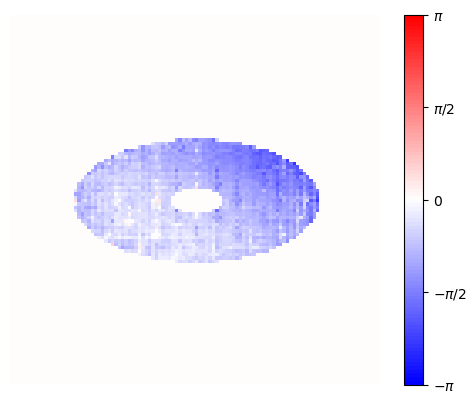

In [8]:
def show_phase(phase):
    phase_unwrapped = unwrap_phase(phase)
    # color map
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> W -> B
    cmap_name = 'custom_diverging'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    # crop center region
    size = phase.shape[0]
    range = size//6
    img = phase_unwrapped[size//2-range:size//2+range, size//2-range:size//2+range]

    fig, ax = plt.subplots()
    cax = ax.imshow(img, cmap=cm, vmin=-np.pi, vmax=np.pi)  # Adjust the limits to -pi to pi for your use case
    plt.axis('off')
    
    # Create colorbar
    cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$']) 
    
    plt.show()

lens_recon = lens_tensor.detach().cpu().numpy()

show_phase(np.angle(lens_recon)*FILTER)

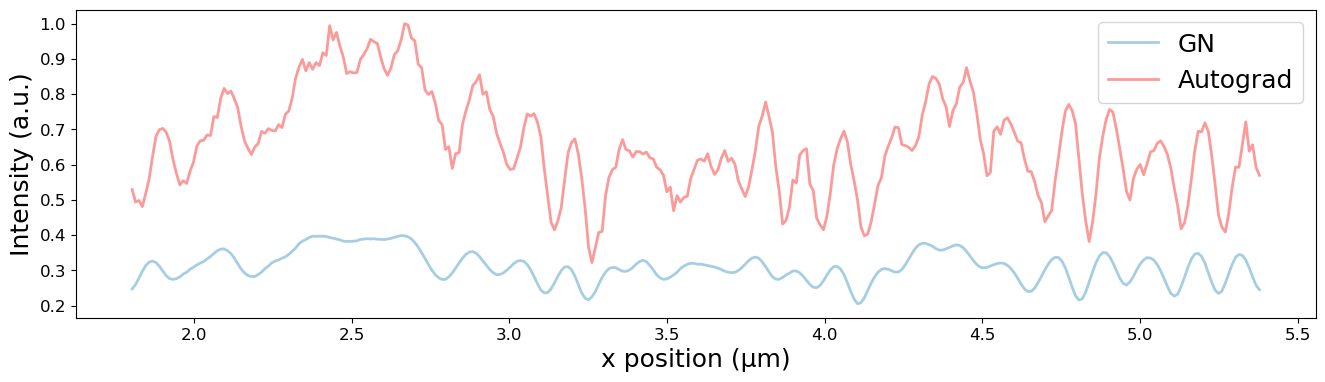

In [14]:
# Convert tensors to NumPy arrays
spectrum_recon = spectrum_tensor.detach().cpu().numpy()
object_recon = ift(spectrum_recon)

line_index = 260
# Extract the lines for comparison
line1 = np.abs(object_guess[:, line_index])
line2 = np.abs(object_recon[:, line_index])

# Normalize the lines (scale to max value = 1)
line1 /= np.max(line2)
line2 /= np.max(line2)

# Define colors
pastel1 = plt.colormaps['Paired']
color1 = pastel1.colors[0]
color2 = pastel1.colors[4]

# X-axis values in micrometers
x_vals = np.linspace(x_m[0] * 1e6, x_m[-1] * 1e6, object_guess.shape[1])

# Create the figure
plt.figure(figsize=(16, 4))
plt.plot(x_vals, line1, label='GN', color=color1, linewidth=2)
plt.plot(x_vals, line2, label='Autograd', color=color2, linewidth=2)

# Labels and legend with increased font size
plt.xlabel('x position (µm)', fontsize=18)
plt.ylabel('Intensity (a.u.)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=18)

# Display the plot
plt.show()



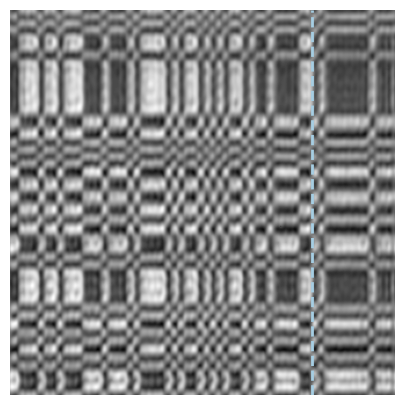

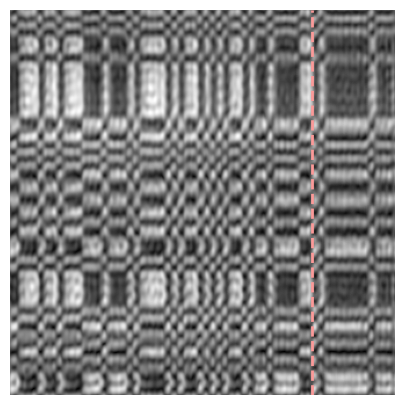

In [10]:

# Plot object_guess
plt.figure(figsize=(6, 5))
plt.imshow(np.abs(object_guess), cmap='gray', extent=[x_m[0]*1e6, x_m[-1]*1e6, x_m[-1]*1e6, x_m[0]*1e6])
plt.axvline(x=x_vals[line_index], color=color1, linestyle='--', linewidth=2, label='GN Line Section')
plt.xlabel('x position (µm)', fontsize=14)
plt.ylabel('y position (µm)', fontsize=14)
plt.axis('off')
plt.show()

# Plot object_recon
plt.figure(figsize=(6, 5))
plt.imshow(np.abs(object_recon), cmap='gray', extent=[x_m[0]*1e6, x_m[-1]*1e6, x_m[-1]*1e6, x_m[0]*1e6])
plt.axvline(x=x_vals[line_index], color=color2, linestyle='--', linewidth=2, label='Autograd Line Section')
plt.xlabel('x position (µm)', fontsize=14)
plt.axis('off')
plt.show()